In [1]:
import pandas as pd

In [2]:
# Выгрузим из датасета train первый 10000000 строк для приемлемой работы

train = pd.read_csv('train.csv', sep=',', index_col=0,
                       dtype = {'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 
                                'content_type_id': 'int8', 'task_container_id': 'int16', 'user_answer': 'int8', 
                                'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                                'prior_question_had_explanation': 'boolean'
                               }, nrows=10000000
                      )
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 314.7 MB


### Для удобства анализа приведем последний столбец к числовому типу





In [3]:
for i in range(train.shape[0]):
    if pd.isna(train['prior_question_had_explanation'][i]) == True:
        train['prior_question_had_explanation'][i] = False
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('int8')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  int8   
dtypes: float32(1), int16(2), int32(1), int64(1), int8(4)
memory usage: 305.2 MB


## 1. Исследуем данные Train


In [4]:
# Исследуем количество уникальных значений для всех столбцов
unique_list = []
for col in train.columns:
    item = (col, train[col].nunique(), train[col].dtype)
    unique_list.append(item)
unique_counts = pd.DataFrame(unique_list,
                             columns=['Column_Name', 'Num_Unique', 'Type']
                            ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts)

,Column_Name,Num_Unique,Type
0,content_type_id,2,int8
1,prior_question_had_explanation,2,int8
2,answered_correctly,3,int8
3,user_answer,5,int8
4,prior_question_elapsed_time,2583,float32
5,task_container_id,10000,int16
6,content_id,13749,int16
7,user_id,39491,int32
8,timestamp,7534842,int64


In [5]:
# Данные с неуникальными значениями в столбцах можно исследовать дополнительно:

train['content_type_id'].value_counts(normalize=True) 
train['content_type_id'].value_counts()[0] 
train['content_type_id'].value_counts()[1] 

# 98% активновти студентов приходится на ответы на вопросы:
# Всего ответов на вопросы: 9804604
# Всего просмотров лекций: 195396

195396

In [6]:
#Исследуем соотношение правильных и неправильных овтетов, исключая из рассмотрения лекции:

train[train['answered_correctly'] != -1]['answered_correctly'].value_counts(normalize=True) 
train[train['answered_correctly'] != -1]['answered_correctly'].value_counts()[1] 
train[train['answered_correctly'] != -1]['answered_correctly'].value_counts()[0]
train[train['answered_correctly'] != -1]['answered_correctly'].mean()

# 66% составляют правильные ответы, 34% - неправильные
# всего 6457425 правильных ответов и 3347179 неправильных
# 0,659 cредний балл студента

0.6586115053703342

In [7]:
# Вычислим среднее время решения вопроса

train['prior_question_elapsed_time'].mean()

25307.6328125

In [8]:
# Вычислим средние значения по всем данным:

train[train['content_type_id'] == 0].shape[0] / train['user_id'].nunique()
train[train['answered_correctly'] != -1]['answered_correctly'].sum() / train['user_id'].nunique()
train[train['content_type_id'] == 1].shape[0] / train['user_id'].nunique()
train['prior_question_had_explanation'].sum() / train['user_id'].nunique()


# Cреднее число отвеченных вопросов: 248.27
# Среднее кол-во правильных ответов: 163.51
# Среднее число просмотренных лекций: 4.95
# Среднее число виденных объяснений: 224.24


224.24235901851054

In [9]:
# Выясним, есть ли разница в % правильных ответов в зависимости от:
# 1. Времени начала сессии
# 2. Среднего времени ответа студента на вопрос
# 3. Видел ли студент правильный ответ на предыдущее занятие

pd.DataFrame({'timestamp': train[train['answered_correctly'] != -1]['timestamp'].groupby(train['answered_correctly']).mean(),
              'prior_questions_time': train[train['answered_correctly'] != -1]['prior_question_elapsed_time'].groupby(train['answered_correctly']).mean(),
              'had_explanation': train[train['answered_correctly'] != -1]['prior_question_had_explanation'].groupby(train['answered_correctly']).sum()
             }
            )

# Можно сделать следующие выводы:
# - чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты 
# (т.е. успешность коррелирует со временем, проведенным на платформе)
# - студенты, тратящие меньше времени на решение, чаще отвечают правильно
# - если студент видел объяснение предыдущий задачи, вероятность правильного ответа удваивается

,timestamp,prior_questions_time,had_explanation
answered_correctly,,,
0,7.046183e+09,25704.232422,2880081.0
1,7.801606e+09,25357.035156,5975474.0


### Выводы
#### 1. Чем ближе к началу сессии вопрос, тем менее успешно его проходят студенты (т.е. успешность коррелируется со временем, проведенным на платформе)
#### 2. Студенты в среднем тратят меньше времени на правильный ответ, чем на неправильный.
#### 3. Если студент видел объяснение предыдущий задачи, он в 2 раза чаще отвечает правильно, чем неправильно

## Cоздадим новый DataFrame c данными, агрегированными по студентам


In [10]:
# Cоставим новый датафрейм по уникальным id студентов:
# Сформируем списки для студентов

students_lister = list(train['user_id'].unique())
users_q = len(students_lister)

In [11]:
# Поскольку число уникальных студентов слишком велико для быстрой обработки, 
# возьмем из нее 500 уникальных и проанализируем их активность:

students_lister = students_lister[:500]

In [12]:
# Посчитаем время на платформе для каждого студента:

time = []
for student in students_lister:
    t = train[train['user_id'] == student]['timestamp'].max()
    time.append(t)


In [13]:
# Количество отвеченных вопросов:

ques_quant = []
for student in students_lister:
    q = train[(train['user_id'] == student) & (train['content_type_id'] == 0)]['content_type_id'].count()
    ques_quant.append(q)

In [14]:
# Средний балл студента: 

av_grade = []
for student in students_lister:
    g = train[(train['user_id'] == student) & (train['answered_correctly'] != -1)]['answered_correctly'].mean()
    av_grade.append(g)

In [15]:
# Кодичество просмотренных лекций:

lec_watched = []
for student in students_lister:
    l = train[train['user_id'] == student]['content_type_id'].sum()
    lec_watched.append(l)

In [16]:
# Количество приведенных объяснений на предыдущие вопросы:

expl_watched = []
for student in students_lister:
    e = train[train['user_id'] == student]['prior_question_had_explanation'].sum()
    expl_watched.append(e)

In [17]:
# Cреднее время затраченное студентом на вопрос:

ques_time = []
for student in students_lister:
    qt = train[(train['user_id'] == student)]['prior_question_elapsed_time'].mean()
    ques_time.append(qt)
    

In [18]:
# Сформируем таблицу по показателям выборки студентов приведенных выше:

students = pd.DataFrame({'user_id': students_lister,
                        'time': time,
                        'ques_quant': ques_quant,
                        'av_grade': av_grade,
                        'lec_watched': lec_watched,
                        'expl_watched': expl_watched,
                         'ques_time': ques_time
                       }
                      )
students = students.astype({'user_id': 'int32',
                            'time': 'int64',
                            'ques_quant': 'int16', 
                            'av_grade': 'float32',
                            'lec_watched': 'int16',
                            'expl_watched': 'int16',
                            'ques_time': 'float32'
                           })

In [19]:
students.head()

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
0,115,668090043,46,0.695652,0,6,19933.310547
1,124,571323,30,0.233333,0,0,18793.000000
2,2746,835457,19,0.578947,1,11,18055.554688
3,5382,2101551456,125,0.672000,3,113,36048.386719
4,8623,862338736,109,0.642202,3,96,26107.408203


In [20]:
# Проведем сравнение нашей выборки и общих данных:

students.describe()

# Наша выборка отличается от нашего датасета:
# 1. Cредняя успеваемость у нашей группы ниже, чем у полного набора данных, 
# 2. Cреднее число просмотренных лекций и объяснений выше (за счет относительно небольшого кол-ва очень активно учащихся студентов
# это видно из смещения кол-ва отвеченных вопросов, просмотренных лекций и объяснений в верхний квартиль и высокой дисперсии)
# 3. Все значения укладываются в среднеквадратическое отклонение, поэтому можем считать их несущественными для результатов анализа

,user_id,time,ques_quant,av_grade,lec_watched,expl_watched,ques_time
count,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000,499.000000
mean,1.468722e+06,5.361427e+09,276.574000,0.554668,5.240000,253.600000,23859.998047
std,8.476328e+05,1.025473e+10,757.372753,0.165881,17.461851,751.298414,7225.852539
min,1.150000e+02,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1344.862061
25%,7.444190e+05,1.395153e+06,30.000000,0.441731,0.000000,9.000000,19370.302734
50%,1.514318e+06,4.714174e+08,45.000000,0.580850,0.000000,22.500000,22924.494141
75%,2.201334e+06,5.065056e+09,171.750000,0.674960,2.000000,142.000000,26889.037109
max,2.909984e+06,6.370152e+10,7476.000000,1.000000,181.000000,7465.000000,60351.351562


<AxesSubplot:>

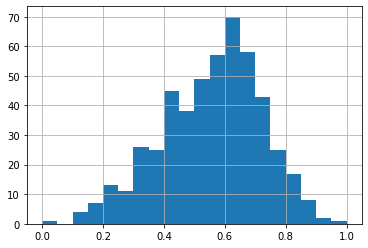

In [21]:
# Приведем гистограмму распределения средних оценок среди студентов

students['av_grade'].hist(bins=20)

In [22]:
students['av_grade'].median()

0.5808496475219727

### Проведем анализ успешности студента от:
#### 1. Времени, проведенном студентами на платформе
#### 2. Количества сделанных заданий
#### 3. Количества приведенных объяснений
#### 4. Количества времени затраченного на один вопрос
#### 5. Количества просмотренных лекций

<AxesSubplot:xlabel='av_grade', ylabel='time'>

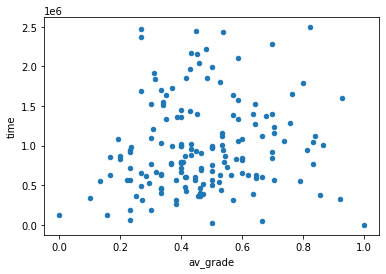

In [23]:
# Построим диаграмму рассеяния, показывающую зависимость правильных ответов от веремени, проведенного на платформе:
# (чтобы убрать выбросы, ограничим время 3000000)

students[students['time'] < 3000000].plot.scatter(x='av_grade', y='time')

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

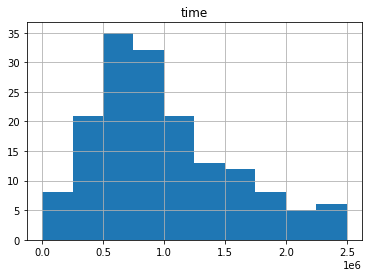

In [24]:
# Посмотрим на гистограмме, в какой момент большинство студентов прекращает занятия:

students[students['time'] < 3000000].hist(column=['time'])

# Мы видим, что после 1000000 милисекунд (=17 минут) 1/5 часть студентов не продолжает обучения, 
# после 2500000 милисекунд (=42 минуты) учебу бросает уже треть
# Получается, то, что мы изначально сочли выбросами - это наша основная рабочая выборка, которую надо исследовать, 
# чтобы понять влияние факторов на успеваемость. 

In [25]:
# строка для проверки данных отсечения:

students[students['time'] < 2500000].shape

(161, 7)

<AxesSubplot:xlabel='av_grade', ylabel='time'>

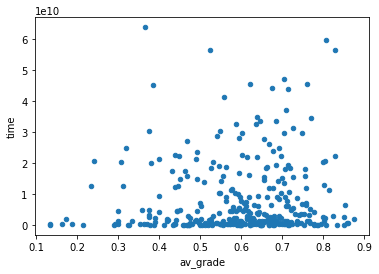

In [27]:
# Построим диаграмму рассеяния для студентов, не бросивших учебу в течение 1го часа:

students[students['time'] > 3000000].plot.scatter(x='av_grade', y='time')

# Видим, что успеваемость растет с течением времени

<AxesSubplot:title={'center':'av_grade'}, xlabel='[q_group]'>

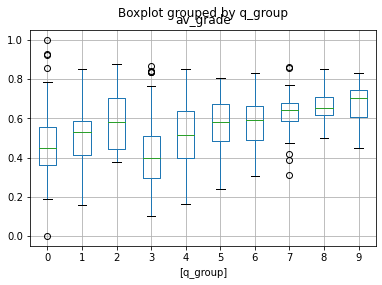

In [28]:
# Построим новый столбец с группировкой по количеству отвеченных вопросов и построим диаграмму размаха:

def ques_convert(e):
    if e < students['ques_quant'].quantile(0.1): return 0
    elif e < students['ques_quant'].quantile(0.2): return 1
    elif e < students['ques_quant'].quantile(0.3): return 2
    elif e < students['ques_quant'].quantile(0.4): return 3
    elif e < students['ques_quant'].quantile(0.5): return 4
    elif e < students['ques_quant'].quantile(0.6): return 5
    elif e < students['ques_quant'].quantile(0.7): return 6
    elif e < students['ques_quant'].quantile(0.8): return 7
    elif e < students['ques_quant'].quantile(0.9): return 8
    else: return 9
    
students['q_group'] = students['ques_quant'].apply(ques_convert)

students.boxplot(column=['av_grade'], by=['q_group'])

# Замечаем странную просадку в четвертом квартале

In [29]:
students['ques_quant'].quantile(0.4)

31.600000000000023

array([[<AxesSubplot:title={'center':'ques_quant'}>]], dtype=object)

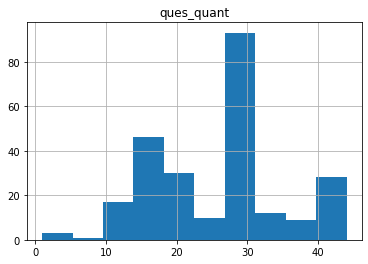

In [30]:
# Можем предположить, что первые вопросы могут выводить студентов из успешного ритма
# Но если студент отвечает больше, чем на 34 вопроса, он постепенно начинает улучшать свои показатели и результаты улучшаются
# На гистограме видно, что 32 вопроса - порог отсечения для многих студентов из нашей выборки

students[(students['ques_quant'] < students['ques_quant'].quantile(0.5))].hist(column=['ques_quant'])

<AxesSubplot:xlabel='av_grade', ylabel='expl_watched'>

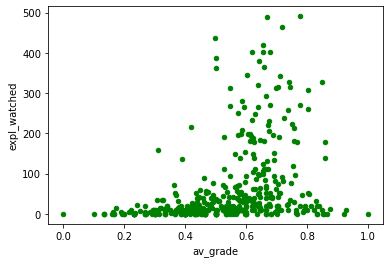

In [32]:
# Построим диаграмму рассеяния, показывающую зависимость правильных ответов от количества виденных объяснений:

students[(students['expl_watched'] < 500)].plot.scatter(x='av_grade', y='expl_watched', c='green')

In [33]:
# Построим новый столбец с группировкой по количеству правильных ответов и построим диаграмму размаха:

def expl_convert(e):
    if e < students['expl_watched'].quantile(0.1): return 0
    elif e < students['expl_watched'].quantile(0.2): return 1
    elif e < students['expl_watched'].quantile(0.3): return 2
    elif e < students['expl_watched'].quantile(0.4): return 3
    elif e < students['expl_watched'].quantile(0.5): return 4
    elif e < students['expl_watched'].quantile(0.6): return 5
    elif e < students['expl_watched'].quantile(0.7): return 6
    elif e < students['expl_watched'].quantile(0.8): return 7
    elif e < students['expl_watched'].quantile(0.9): return 8
    else: return 9
    
students['e_group'] = students['expl_watched'].apply(expl_convert)

students['expl_watched'].quantile(0.5)

22.5

array([[<AxesSubplot:title={'center':'expl_watched'}>]], dtype=object)

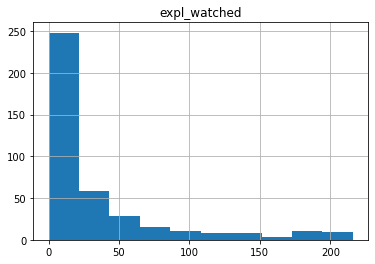

In [34]:
# Здесь мы видим, что 34 вопроса - порог отсечения для многих студентов

students[(students['expl_watched'] < students['expl_watched'].quantile(0.8))].hist(column=['expl_watched'])

<AxesSubplot:title={'center':'av_grade'}, xlabel='[e_group]'>

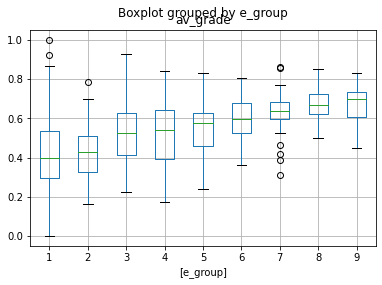

In [35]:
students.boxplot(column=['av_grade'], by=['e_group'])

# Виден четкий тренд на повышение оценки с ростом количества просмотренных объяснений

<AxesSubplot:xlabel='av_grade', ylabel='lec_watched'>

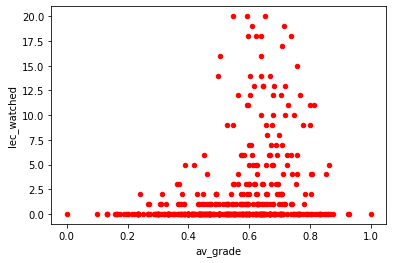

In [37]:
# Построим диаграмму рассеяния, показывающую зависимость правильных ответов от количества просмотренных лекций:

students[students['lec_watched'] < 21].plot.scatter(x='av_grade', y='lec_watched', c='red')

# Заметим, что экстремальные выбросы можно убрать, ограничив число 21 лекцией

<AxesSubplot:title={'center':'av_grade'}, xlabel='[lec_watched]'>

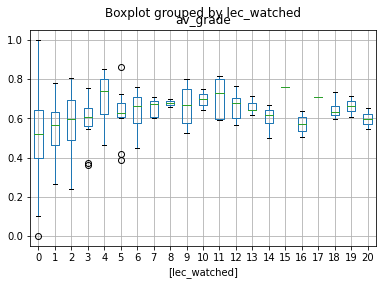

In [38]:
# Построим диаграмму размаха, показывающую зависимость правильных ответов от количества просмотренных лекций:

students[students['lec_watched'] < 21].boxplot(column=['av_grade'], by=['lec_watched'])

# Мы видим, что даже просмотр 1 лекции повышает средний балл и значительно повышает минимальную оценку студента.
# Максимальный эффект достигается при просмотре 4-11 лекций, после чего эффективность просмотров снижается

# Выводы по выборке из общего объема данных по 500 студентам:

#### 1. Треть студентов бросает учебу, проведя на платформе менее 42 минут. За это время, вероятно, они не успевают почувствовать эффект, либо им просто что-то не нравится (недостаточно мотивации / слишком сложные вопросы / неудобный интерфейс и т.д.).
#### 2. Если студент потратил на занятия не менее 55 часов, его оценка становится устойчиво выше средней и продолжает расти со временем.
#### 3. Если курс не пройден за ~ полгода, оценка становится нестабильной. Т.е. стоит не только стимулировать студентов не бросать занятия после первого подхода, но и закончить курс за первые полгода обучения.
#### 4. Анализ данных по количеству отвеченных вопросов подсказывает, что первые вопросы сильно демотивируют учащихся. Большая часть не преодолевает порог в 32 вопроса. Следует стимуляровать студентов к ответу хотя бы на первые 60 вопросов, чтобы добиться устойчивого улучшения результатов и мотивации к дальнейшему обучению.
#### 5. С ростом количества просмотренных объяснений устойчиво растет успеваемость студентов.
#### 6. Если студент посмотрит более 4х лекций, его успеваемость значительно возрастет. При этом просмотр более 11 лекций по какой-то причине не улучшает ситуацию.

## Исследуем данные questions

In [39]:
questions = pd.read_csv('questions.csv', sep=',',
                        dtype = {'question_id': 'int16', 'bundle_id': 'int16', 'correct_answer': 'int8',
                                 'part': 'int8', 'tags': 'object'
                               })
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [40]:
# Исследуем количество уникальных значений для разных колонок:

unique_list_q = []
for col in questions.columns:
    item = (col, questions[col].nunique(), questions[col].dtype)
    unique_list_q.append(item)
unique_counts_q = pd.DataFrame(unique_list_q,
                               columns=['Column_Name', 'Num_Unique', 'Type']
                              ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_q)

,Column_Name,Num_Unique,Type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9765,int16
4,question_id,13523,int16


In [41]:
questions['question_id'].groupby(questions['bundle_id']).count().max()
questions['part'].value_counts(normalize=True)
questions['tags'].describe()

# Часть вопросов объединены по bundle_id в блоки до 5 вопросов, хотя большинство представлены по одиночке
# Задачи разделены по темам на 7 разделов, больше всего посвящено 5му разделу, 2, 3 и 4

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

In [42]:
q_tags = set()
for tag in questions['tags']:
    try:
        for t in tag.split():
                q_tags.add(int(t))
    except:
        q_tags.add(int(t))
len(q_tags)

# Можно провести дополнительное исследование вопросов, используя кластеризацию по 188 дополнительным признакам 'tags'

188

### Для дальнейшего исследования вопросов создадим единую таблицу по их ID с данными Train

In [44]:
tmp_df = train.loc[(train.content_type_id == 0), ['content_id', 'answered_correctly']]

# Столбец question_id:

q_list = list(tmp_df['content_id'].unique())
len(q_list)

# Всего 13500 уникальных вопросов. Мы берем этот список из файла Train, чтобы иметь правильный порядок данных

13500

In [45]:
# Столбцы :
# q_quant - общее количество ответов для каждого id
# correct_quant - количество правильных ответов для каждого id

q_quant = []
correct_quant = []
for q in q_list:
    tmp = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].count()
    tmp1 = tmp_df[tmp_df['content_id'] == q]['answered_correctly'].sum()
    q_quant.append(tmp)
    correct_quant.append(tmp1)

In [46]:
# Запишем полученные данные в единую таблицу:

q_ex = pd.DataFrame({'question_id': q_list,
                        'q_quant': q_quant,
                        'correct_quant': correct_quant
                       }
                      )
q_ex = q_ex.astype({'question_id': 'int16', 'q_quant': 'int32', 'correct_quant': 'int32'})

In [47]:
# Внесем полученные данные в таблицу questions (пересечением), удалив ненужные столбцы:

questions = questions.drop('correct_answer', axis=1)
questions = pd.merge(questions, q_ex, how='inner')

In [48]:
# Добавим дополнительный столбец: процент правильных ответов(correct_percent)

questions['correct_percent'] = questions['correct_quant'] / questions['q_quant']
questions.describe()

,question_id,bundle_id,part,q_quant,correct_quant,correct_percent
count,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000
mean,6760.953778,6760.465556,4.262296,726.266963,478.327778,0.712115
std,3905.579569,3905.539487,1.651777,1142.219033,642.560321,0.169706
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3377.750000,3377.250000,3.000000,173.000000,122.000000,0.608498
50%,6757.500000,6757.000000,5.000000,466.000000,317.000000,0.735702
75%,10147.250000,10145.000000,5.000000,849.000000,585.000000,0.840664
max,13522.000000,13522.000000,7.000000,21103.000000,14866.000000,1.000000


In [49]:
questions

,question_id,bundle_id,part,tags,q_quant,correct_quant,correct_percent
0,0,0,1,51 131 162 38,691,628,0.908828
1,1,1,1,131 36 81,726,649,0.893939
2,2,2,1,131 101 162 92,4501,2531,0.562319
3,3,3,1,131 149 162 29,2276,1776,0.780316
4,4,4,1,131 5 162 38,3153,1980,0.627973
...,...,...,...,...,...,...,...
13495,13518,13518,5,14,86,68,0.790698
13496,13519,13519,5,8,86,50,0.581395
13497,13520,13520,5,73,82,56,0.682927
13498,13521,13521,5,125,87,68,0.781609


In [50]:
# Посмотрим дополнительные условия, от которых может зависеть успешность ответа на вопрос: от номера раздела в тесте TOEIC ('part')

questions.groupby('part').mean()['correct_percent'].sort_values()

# По мере продвижения по разделам, видимо, сложность курса возрастает. 
# 5й раздел содержит максимальное число леций и заданий, однако средняя успеваемость студентов для него самая низкая.

part
5    0.665941
6    0.699149
7    0.723305
4    0.732642
2    0.748136
3    0.751740
1    0.819349
Name: correct_percent, dtype: float64

## Исследуем данные lectures

In [51]:
lectures = pd.read_csv('lectures.csv', sep=',',
                      dtype = {'lecture_id': 'int16', 'tag': 'int16', 
                               'part': 'int8', 'type_of': 'object'})
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


In [52]:
# Исследуем количество уникальных значений для разных колонок

unique_list_lec = []
for col in lectures.columns:
    item = (col, lectures[col].nunique(), lectures[col].dtype)
    unique_list_lec.append(item)
unique_counts_lec = pd.DataFrame(unique_list_lec,
                                 columns=['Column_Name', 'Num_Unique', 'Type']
                                ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_lec)


,Column_Name,Num_Unique,Type
0,type_of,4,object
1,part,7,int8
2,tag,151,int16
3,lecture_id,418,int16


In [53]:
lectures['part'].value_counts(normalize=True)
lectures['type_of'].value_counts(normalize=True)
lectures['tag'].value_counts().head()

136    7
27     6
161    6
74     6
134    6
Name: tag, dtype: int64

In [54]:
# Для дальнейшего исследования лекций создадим единую таблицу по их ID с данными Train.

l_list = list(train[train['content_type_id'] == 1]['content_id'].unique())
len(l_list)

# Всего 402 уникальных лекций. Мы берем этот список из файла Train, чтобы иметь правильный порядок данных

402

In [55]:
# Посчитаем количество просмотров лекций для каждого id:

l_quant = []
for l in l_list:
    tmp_l = train[(train['content_id'] == l)]['content_id'].count()
    l_quant.append(tmp_l)

In [56]:
# Запишем полученные данные в единую таблицу:

l_ex = pd.DataFrame({'lecture_id': l_list,
                        'l_quant': l_quant
                       }
                      )
l_ex = l_ex.astype({'lecture_id': 'int16', 'l_quant': 'int32'})

In [57]:
# Внесем полученные данные в таблицу lectures (пересечением):

lectures = pd.merge(lectures, l_ex, how='inner')
display(lectures)

,lecture_id,tag,part,type_of,l_quant
0,89,159,5,concept,2437
1,100,70,1,concept,1794
2,185,45,6,concept,4701
3,192,79,5,solving question,1111
4,317,156,5,solving question,1067
...,...,...,...,...,...
397,32491,179,5,solving question,163
398,32535,8,5,solving question,348
399,32570,113,3,solving question,285
400,32625,142,2,concept,774


In [58]:
# Общий рейтинг популярности для лекций:

lectures.sort_values(by=['l_quant'], ascending=False).head()

,lecture_id,tag,part,type_of,l_quant
121,10688,39,7,concept,13548
5,335,114,2,concept,5952
44,3852,161,4,solving question,5754
2,185,45,6,concept,4701
61,5694,140,2,concept,4468


In [59]:
# Рейтинг популярности для лекций, в зависимости от раздела:

lectures.groupby('part').sum()['l_quant'].sort_values(ascending=False)

part
5    122459
2     55625
6     48867
1     35155
7     26280
4     18916
3     15302
Name: l_quant, dtype: int32

In [60]:
# Рейтинг относительной популярности лекций по разделам:

for part in range(1, 8):
    print(part, lectures.groupby('part').sum()['l_quant'].sort_values(ascending=False)[part]/lectures['part'].value_counts()[part])
    
# Наибольшее число просмотров имеет лекция из 7го раздела, при этом самая высокая средневзвешенная популярность у лекций 2 раздела

1 651.0185185185185
2 993.3035714285714
3 805.3684210526316
4 610.1935483870968
5 868.5035460992908
6 698.1
7 847.741935483871


In [61]:
# Рейтинг популярности для лекций, в зависимости от тега лекции:

lectures.groupby('tag').sum()['l_quant'].sort_values(ascending=False).head()

tag
39     13548
161     9147
27      7995
62      7900
114     6803
Name: l_quant, dtype: int32

## Построим новую таблицу для дополнительного анализа отдельных разделов

In [66]:
# Столбец part

part_list = list(range(1, 8))

# Столбец количество вопросов в каждом разделе

ques_quant_p = [questions[questions.part == p]['question_id'].count() for p in range(1,8)]

# Столбец количество ответов в каждом разделе

ans_quant_p = [questions[questions.part == p]['q_quant'].sum() for p in range(1,8)]

# Столбец количество правильных ответов в каждом разделе

right_quant_p = [questions[questions.part == p]['correct_quant'].sum() for p in range(1,8)]

# Столбец относительное количество правильных ответов в каждом разделе

right_perc_p = [round(questions[questions.part == p]['correct_quant'].sum()/questions[questions.part == p]['q_quant'].sum(), 3) for p in range(1,8)]

# Столбец количество лекций в каждом разделе

lec_quant_p = [lectures[lectures.part == p]['lecture_id'].count() for p in range(1,8)]

# Столбец количество просмотров лекций в каждом разделе

lec_view_p = [lectures[lectures.part == p]['l_quant'].sum() for p in range(1,8)]

# Популярность лекций в каждом разделе

lec_pop_p = [lectures[lectures.part == p]['l_quant'].sum()/lectures[lectures.part == p]['lecture_id'].count() for p in range(1,8)]

# Нормализованная популярность лекций в каждом разделе

norm_lec_pop_p = [round(pop / max(lec_pop_p), 3) for pop in lec_pop_p]

# Запишем полученные данные в единую таблицу

part_df = pd.DataFrame({'part': part_list,
                        'ques_quant_p': ques_quant_p,
                        'ans_quant_p': ans_quant_p,
                        'right_quant_p': right_quant_p,
                        'right_perc_p': right_perc_p,
                        'lec_quant_p': lec_quant_p,
                        'lec_view_p': lec_view_p,
                        'norm_lec_pop_p': norm_lec_pop_p
                       }
                      )
part_df = part_df.astype({'part': 'int8',
                        'ques_quant_p': 'int16',
                        'ans_quant_p': 'int64',
                        'right_quant_p': 'int64',
                        'right_perc_p': 'float32',
                        'lec_quant_p': 'int16',
                        'lec_view_p': 'int32',
                        'norm_lec_pop_p': 'float32'
                       })

part_df.sort_values(by='right_perc_p', ascending=False)


,part,ques_quant_p,ans_quant_p,right_quant_p,right_perc_p,lec_quant_p,lec_view_p,norm_lec_pop_p
0,1,992,738264,550822,0.746,54,35155,0.655
1,2,1647,1862272,1324262,0.711,56,55625,1.000
2,3,1559,849569,598613,0.705,19,15302,0.811
5,6,1207,1048356,701305,0.669,70,48867,0.703
6,7,1150,500714,332210,0.663,31,26280,0.853
3,4,1439,799656,507638,0.635,31,18916,0.614
4,5,5506,4005773,2442575,0.610,141,122459,0.874


## Выводы:
#### 1. Лекции бывают 4 типов: вступление, постановка целей, изложение материала и решение задач.
#### 2. Задачи и лекции разделены по темам на 7 разделов
#### 3. Большинство лекций посвящены теории, немного меньше - решению задач. Доля остальных несущественна.
#### 4. Наибольшее число просмотров имеет лекция из 7-го раздела.
#### 5. Самая высокая средневзвешенная популярность у лекций 2 раздела.
#### 6. 5-ый раздел - самый насыщенный по материалу, 6-ой и 1-ый - более теоретические, а 3-ий и 4-ый - более прикладные.
#### 7. По мере продвижения по разделам, видимо, сложность курса возрастает.
#### 8. 5-ый раздел содержит максимальное число лекций и заданий, однако средняя успеваемость студентов для него самая низкая.
#### 9. Успеваемость по 4-му и 6-му разделу, вероятно, можно улучшить, добавив в них качественные лекции, а по 7-му разделу - добавив практические задания.